In [1]:
import numpy as np
import pandas as pd
import tqdm
import warnings

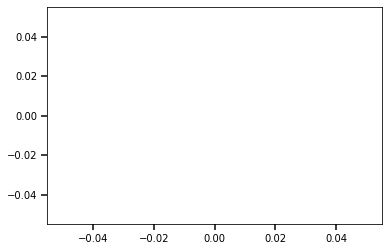

In [15]:
import matplotlib
import matplotlib.pyplot as plt
plt.plot()
matplotlib.style.use( '/Users/zhafen/repos/clean-bold/clean-bold.mplstyle' )
import matplotlib.patheffects as path_effects


In [3]:
import yt
import trident
import unyt as u

In [4]:
import linetools
from linetools.lists.linelist import LineList

# Setup

In [5]:
# Objects for use
ldb = trident.LineDatabase('lines.txt')

In [6]:
ll = LineList('ISM')

read_sets: Using set file -- 
  /Users/zhafen/repos/linetools/linetools/lists/sets/llist_v1.3.ascii
Loading abundances from Asplund2009
Abundances are relative by number on a logarithmic scale with H=12


In [7]:
# Read vpf linelist
with open( './data/linelist_vpfit12.2.dat', 'r' ) as f:
    vpf_raw = f.read().split( '\n' )
    
# Parse it
vpf = {
    'name': [],
    'wavelength': [],
    'gamma': [],
    'f': [],
}
skipped = []
for i, row in enumerate( vpf_raw ):
    
    split_row = row.split()

    try:
        for j, term in enumerate( split_row ):
            try:
                wavelength = float( term )
                break
            except ValueError:
                pass

        name = ''.join( split_row[:j] )
        f = float( split_row[j+1] )
        gamma = float( split_row[j+2] )
    except:
        skipped.append( row )
        continue

    vpf['wavelength'].append( wavelength )
    vpf['name'].append( name )
    vpf['f'].append( f )
    vpf['gamma'].append( gamma )

# Analysis

In [8]:
trident_props = {}
ll_props = {}
vpf_props = { 'f': [], 'gamma': [] }
skipped_linetools = []
skipped_vpf = []
for i, line in enumerate( tqdm.tqdm( ldb.lines_all ) ):
    
    # Retrieve line
    wavelength_int = round(float(line.wavelength), 0)
    def linetools_id( wavelength ):
        return '%s%s %d' % (line.element, line.ion_state, wavelength )
    ll_line = ll[linetools_id(wavelength_int)]
    if ll_line is None:
#         warnings.warn( 'Line ' + linetools_id(wavelength_int) + \
#             ' not found in linetools database. Checking adjacent wavelengths.')
        ll_line = ll[ linetools_id(wavelength_int-1) ]
        if ll_line is None:
            ll_line = ll[ linetools_id(wavelength_int+1) ]
            if ll_line is None:
#                 print( 'No line found in linetools database. Skipping {}.'.format( line.name ) )
                skipped_linetools.append( line.name )
                continue
                
    # Retrieve vpf line
    close_inds = np.where( np.isclose( ll_line['wrest'].value, vpf['wavelength'] ) )[0]
    if len( close_inds ) != 1:
        skipped_vpf.append( line.name )
        continue
    vpf_ind = close_inds[0]
        
    # Trident
    for key, item in line.__dict__.items():
        if key not in trident_props:
            assert i == 0, "Should only update on first pass."
            trident_props[key] = []
        trident_props[key].append( item )
        
    
    # Linetools
    for key, item in ll_line.items():
        if key not in ll_props:
            assert i == 0, "Should only update on first pass."
            ll_props[key] = []
        if key == 'gamma':
            item = item.value
        ll_props[key].append( item )
         
    # Vpfit
    vpf_props['f'].append( vpf['f'][vpf_ind] )
    vpf_props['gamma'].append( vpf['gamma'][vpf_ind] )

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 213/213 [00:00<00:00, 717.70it/s]


# Plot

In [11]:
def plot_vs( ax, x_key, y_key, lims, x_props, y_props ):
    
    significantly_different = np.abs( np.log10( np.array( x_props[x_key] ) / np.array( y_props[y_key] ) )  ) > 0.5
    different_inds = np.where( significantly_different )[0]

    ax.scatter(
        x_props[x_key],
        y_props[y_key],
        color = 'k',
        alpha = 0.5,
    )

    for ind in different_inds:

        text = ax.annotate(
            text = trident_props['name'][ind],
            xy = ( x_props[x_key][ind], y_props[y_key][ind] ),
            xytext = ( 5, 5 ),
            xycoords = 'data',
            textcoords = 'offset points',
        )
        text.set_path_effects([path_effects.Stroke(linewidth=1.5, foreground='white'),
                           path_effects.Normal()])

    ax.set_aspect( 'equal' )
    ax.plot(
        lims,
        lims,
        color = 'k',
        zorder = -10,
    )

    ax.set_xlim( lims )
    ax.set_ylim( lims )

    ax.set_xscale( 'log' )
    ax.set_yscale( 'log' )

## Oscillator Strengths

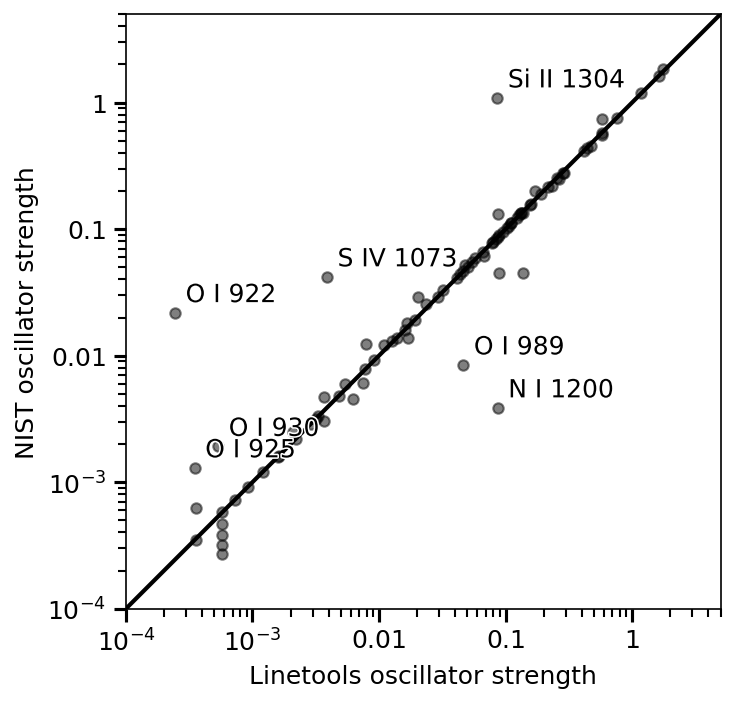

In [19]:
fig = plt.figure()
ax = plt.gca()

plot_vs( ax, 'f', 'f_value', [ 1e-4, 5 ], ll_props, trident_props, )

ax.set_xlabel( 'Linetools oscillator strength' )
ax.set_ylabel( 'NIST oscillator strength' )

plt.savefig( '/Users/zhafen/drafts/cgm_modeling_challenge_paper/figures/NIST_vs_linetools_oscillator_strength.pdf', bbox_inches='tight' )

Text(0, 0.5, 'Trident oscillator strength')

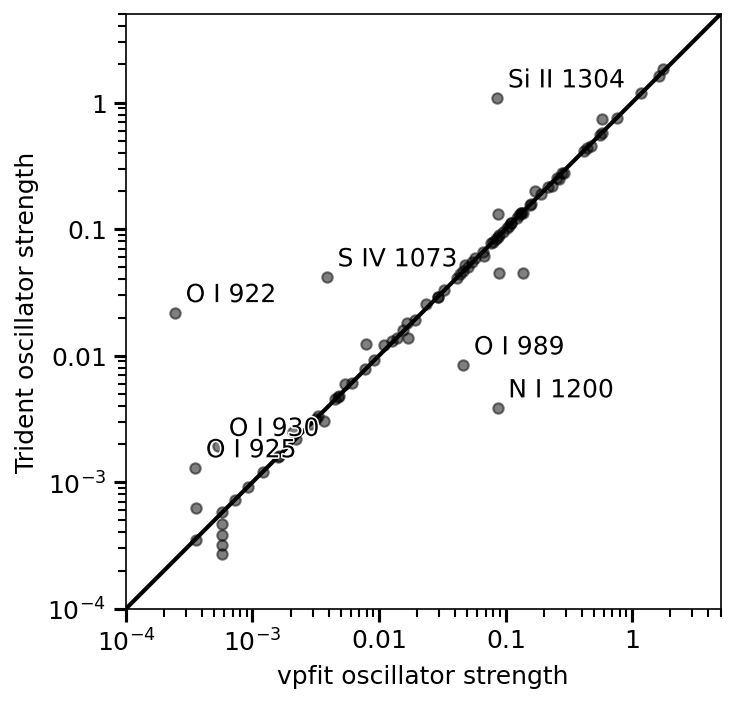

In [17]:
fig = plt.figure()
ax = plt.gca()

plot_vs( ax, 'f', 'f_value', [ 1e-4, 5 ], vpf_props, trident_props, )

ax.set_xlabel( 'vpfit oscillator strength' )
ax.set_ylabel( 'Trident oscillator strength' )

Text(0, 0.5, 'Linetools oscillator strength')

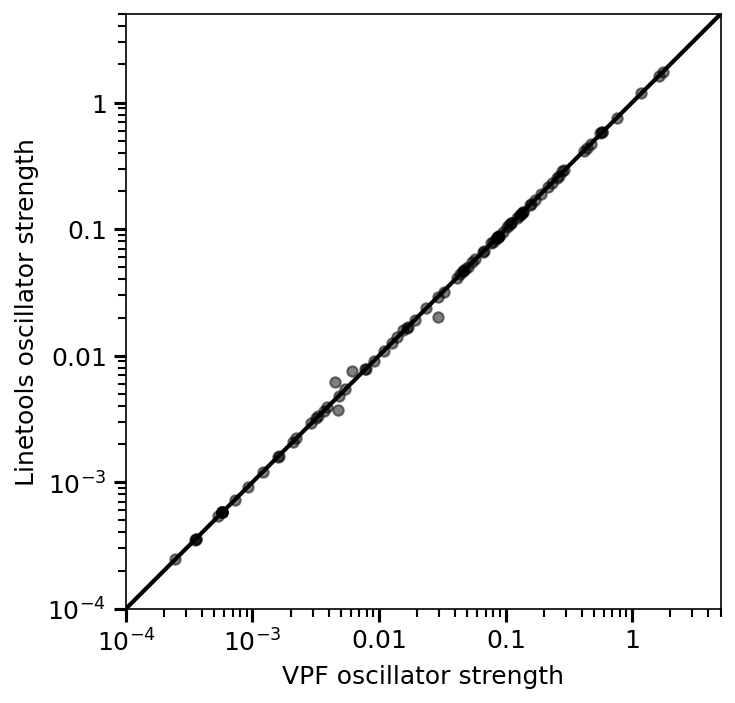

In [18]:
fig = plt.figure()
ax = plt.gca()

plot_vs( ax, 'f', 'f', [ 1e-4, 5 ], vpf_props, ll_props, )

ax.set_xlabel( 'VPF oscillator strength' )
ax.set_ylabel( 'Linetools oscillator strength' )

## Gamma

In [ ]:
fig = plt.figure()
ax = plt.gca()

plot_vs( ax, 'gamma', 'gamma', [ 1e3, 1e11 ], ll_props, trident_props, )

ax.set_xlabel( 'Linetools gamma' )
ax.set_ylabel( 'Trident gamma' )

In [ ]:
fig = plt.figure()
ax = plt.gca()

plot_vs( ax, 'gamma', 'gamma', [ 1e3, 1e11 ], ll_props, vpf_props, )

ax.set_xlabel( 'Linetools gamma' )
ax.set_ylabel( 'Vpf gamma' )